In [2]:
import json, pickle
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, random_clifford_circuit
from gnn import ExpValCircuitGraphModel
from qiskit.quantum_info import Clifford
from qiskit_aer.noise import depolarizing_error, coherent_unitary_error, NoiseModel
from noise_utils import AddNoise

from functools import partial

In [3]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

num_qubit = 4

In [ ]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

# Local, coherent noise
backend_ideal = QasmSimulator() # Noiseless
backend_noisy_coherent, noise_model = AddNoise().add_coherent_noise(seed=0, theta=np.pi * 0.04, uniform=False, add_depolarization=True)

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy_coherent = {'shots': 10000, 'backend': backend_noisy_coherent, 'name': 'noisy_coherent'}

num_qubit = 4

In [4]:
from qiskit.transpiler.exceptions import TranspilerError
import scipy

def generate_data(generating_func, two_q_gate_depths, save_path: str, n_entries_per_file: int, run_config_n):
    for depth in two_q_gate_depths:
        entries = []

        for i in tqdm_notebook(range(n_entries_per_file)):
            success = False
            while not success:
                try:
                    circuit = generating_func(depth)
                    success = True
                except (scipy.linalg.LinAlgError, TranspilerError, np.linalg.LinAlgError) as e:
                    print(f"Ran into an error:, {e}")

            job_ideal = execute(circuit, **run_config_ideal)
            job_noisy = execute(circuit, **run_config_n)

            counts_ideal = job_ideal.result().get_counts()
            counts_noisy = job_noisy.result().get_counts()

            ideal_exp_val = cal_z_exp(counts_ideal)
            noisy_exp_val = cal_z_exp(counts_noisy)

            graph_data = circuit_to_graph_data_json(
                circuit=circuit,
                properties=properties,
                use_qubit_features=True,
                use_gate_features=True,
            )

            entry = ExpValueEntry(
                circuit_graph=graph_data,
                observable=[],
                ideal_exp_value=ideal_exp_val.tolist(),
                noisy_exp_values=[noisy_exp_val.tolist()],
                circuit_depth=circuit.depth()
            )
            to_append = entry.to_dict()
            to_append['circuit'] = circuit
            entries.append(to_append)

        path = f"{save_path}/step_{depth}.pk"
        with open(path, "wb") as f:
            pickle.dump(entries, f)

In [5]:
from qiskit.circuit import Parameter

class IsingModel:

    class Options(dict):
        def __init__(self, *args, **kwargs):
            super().__init__()
            self['nq'] = 4
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4
            self['depth'] = 15
            self.update(*args, **kwargs)

        def config_4q_paper(self):
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_10q_paper(self):
            self['h'] = 1
            self['J'] = 0.5236
            self['dt'] = 1/4


    @classmethod
    def apply_quantum_circuit_layer(cls, qc: QuantumCircuit, ops: 'IsingModel.Options'):
        allq = list(range(ops['nq']))

        qc.rx(2*ops['h']*ops['dt'], allq)

        qc.barrier()
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[1::2])
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)

        qc.barrier()
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[2:-1:2])
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.barrier()

    @classmethod
    def make_quantum_circuit(cls, ops: 'IsingModel.Options'):
        qc = QuantumCircuit(ops['nq'])
        allq = list(range(ops['nq']))

        for step in range(ops['depth']):
            cls.apply_quantum_circuit_layer(qc, ops)

        if ops['measure_basis'] == 'Z':
            pass
        elif  ops['measure_basis'] == 'X':
            qc.h(allq)
        elif  ops['measure_basis'] == 'Y':
            qc.sdg(allq)
            qc.h(allq)
        else:
            raise Exception("Must be X Y or Z")
        qc.measure_all()

        return qc

    @classmethod
    def make_circs_sweep(cls, ops, num_steps, measure_basis):
        ops['measure_basis'] = measure_basis
        ops['depth'] = num_steps
        qc = cls.make_quantum_circuit(ops)
        qc.metadata = {}
        qc.metadata['measure_basis'] = measure_basis
        qc.metadata['depth'] = num_steps
        return qc

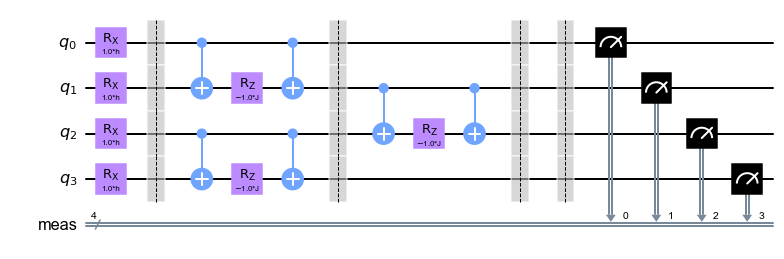

In [5]:
cls = IsingModel
ops = cls.Options()
ops.config_4q_paper()
ops.update({'J': Parameter('J'), 'h': Parameter('h')})
qc = cls.make_circs_sweep(ops, 1, 'Z'), list(range(4))
qc[0].draw('mpl', fold=-1)

# Random Ising Init

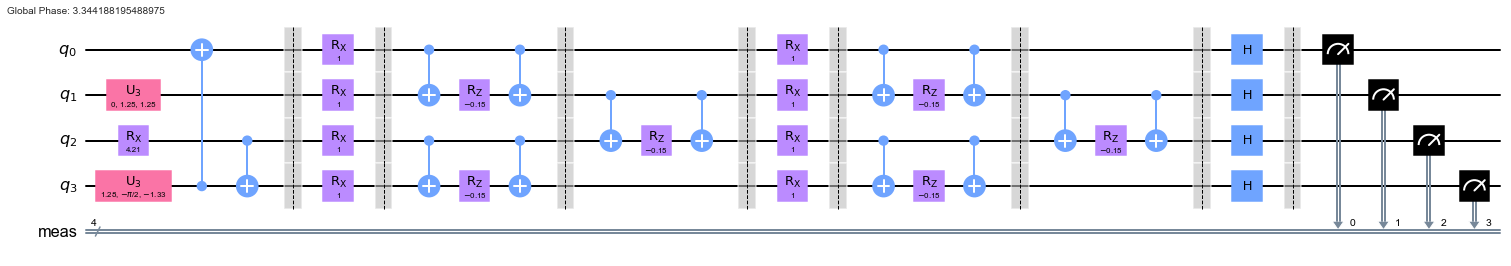

In [9]:
from qiskit.quantum_info import random_statevector
from qiskit.circuit.library import RYGate, RXGate, RZGate, CXGate
from qiskit import QuantumRegister

def generate_random_initial_state():
    qc = QuantumCircuit(4)
    random_state = random_statevector(2**4).data
    qc.initialize(random_state, list(range(4)))
    return qc

def generate_random_initial_num_gate(num_gates=2):
    qr = QuantumRegister(4)
    qc = QuantumCircuit(qr)

    for _ in range(num_gates):
        gate_type = np.random.choice(['rx', 'rz', 'cnot', 'id'])
        qubit_indices = np.random.choice(range(4), size=2, replace=False)

        if gate_type == 'ry':
            theta = 2 * np.pi * np.random.rand()
            qc.append(RYGate(theta), [qr[qubit_indices[0]]])
        elif gate_type == 'rx':
            theta = 2 * np.pi * np.random.rand()
            qc.append(RXGate(theta), [qr[qubit_indices[0]]])
        elif gate_type == 'rz':
            theta = 2 * np.pi * np.random.rand()
            qc.append(RZGate(theta), [qr[qubit_indices[0]]])
        elif gate_type == 'id':
            pass
        elif gate_type == 'cnot':
            theta = 2 * np.pi * np.random.rand()
            qc.append(RXGate(theta), [qr[qubit_indices[0]]])
            qc.append(CXGate(), [qr[qubit_indices[0]], qr[qubit_indices[1]]])

    return qc

def construct_ising_circuit_random_init(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_4q_paper()
    ops.update({'J': J})
    qc_init = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[4];\nrz(0.0007186381718527407) q[1];\nrz(2.4917901988569855) q[1];\nrz(3.3854853863523835) q[3];\nrx(1.2846113715328817) q[3];\ncx q[3],q[0];\nrx(4.212671608894216) q[2];\ncx q[2],q[3];\n')
    qc_init.barrier()
    qc = qc_init.compose(cls.make_circs_sweep(ops, num_steps, basis), list(range(4)))
    return qc

J = 0.15
basis = np.random.choice(list('XYZ'))
random_ising = construct_ising_circuit_random_init(J, basis, 2)
trans_circuit = transpile(random_ising, backend=backend_ideal, optimization_level=3)
trans_circuit.draw('mpl', fold=-1)

In [10]:
h = 1
def construct_random_ising_func_random_init(num_steps, be):
    J = np.random.uniform(0, h, size=1)[0]
    basis = np.random.choice(list('XYZ'))
    random_ising = construct_ising_circuit_random_init(J, basis, num_steps)
    trans_circuit = transpile(random_ising, backend=be, optimization_level=3)
    return trans_circuit

In [ ]:
steps = list(range(15))
generate_data(partial(construct_random_ising_func_random_init, be=backend_noisy), steps, './data/ising_init_from_qasm/train', 300, run_config_n=run_config_noisy)

In [81]:
steps = list(range(15))
generate_data(partial(construct_random_ising_func_random_init, be=backend_noisy), steps, './data/ising_init_from_qasm/val', 100, run_config_n=run_config_noisy)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# Generate Random Ising

In [20]:
def construct_ising_circuit(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_4q_paper()
    ops.update({'J': J})
    qc = cls.make_circs_sweep(ops, num_steps, basis)
    return qc

In [35]:
from qiskit.quantum_info import Pauli
def state_preparation_block(basis):
    sp_circ_block = QuantumCircuit(4)
    for i, p in enumerate(basis[::-1]):
        if p == 'Z':
            pass
        elif p == 'X':
            sp_circ_block.h(i)
        elif p == 'Y':
            sp_circ_block.h(i)
            sp_circ_block.s(i)
    return sp_circ_block

In [60]:
h = 1
def construct_random_ising_func(num_steps, be, state_prep=None):
    J = np.random.uniform(0, h, size=1)[0]
    basis = np.random.choice(list('XYZ'))
    if state_prep is not None:
        np.random.seed(0)
        num_qubits = 4
        qc = QuantumCircuit(num_qubits)
        qc.initialize(random_statevector(2**num_qubits).data, qc.qubits)
        # state_prep_block = state_preparation_block(state_prep)
    random_ising = qc.compose(construct_ising_circuit(J, basis, num_steps), list(range(4)))
    trans_circuit = transpile(random_ising, backend=be, optimization_level=3)
    return trans_circuit

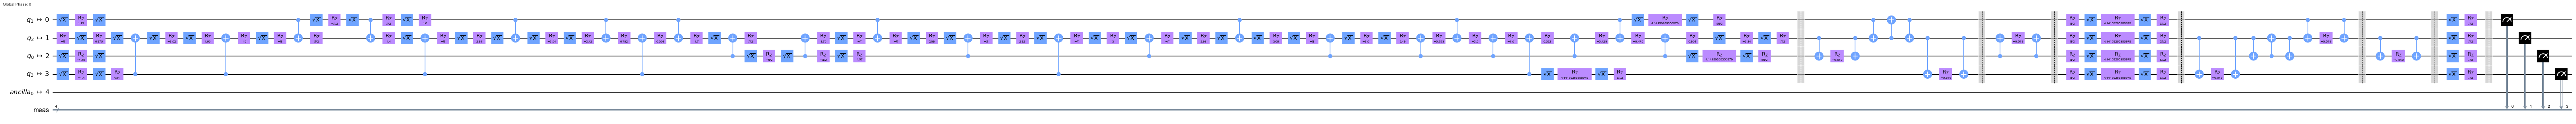

In [61]:
construct_random_ising_func(2, backend_noisy, state_prep='ZXXZ').draw('mpl', fold=-1)

In [ ]:
steps = list(range(10))
generate_data(partial(construct_random_ising_func, be=backend_noisy, state_prep='ZXXZ'), steps, './data/ising_init_random_state/train', 500, run_config_n=run_config_noisy)

In [46]:
steps = list(range(10))
generate_data(partial(construct_random_ising_func, be=backend_noisy, state_prep='ZXXZ'), steps, './data/ising_init_random_state/val', 200, run_config_n=run_config_noisy)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]